In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/FYP/Autism_Screening_Data_Combined.csv'
df = pd.read_csv(file_path)

In [ ]:
df = df[(df['Age'] <= 15) & (df['Age'] >= 12)]

In [ ]:
df['label'] = (df[['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10']].sum(axis=1) >= 6).astype(int)

In [ ]:
x = df.drop(['Class', 'Family_ASD', 'Jauundice', 'Sex', 'label'], axis=1)
y = df['label']
y.value_counts(normalize=True)


,proportion
label,
0,0.525926
1,0.474074


In [ ]:
print(x.shape)
print(y.shape)


(6075, 11)
(6075,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)



In [ ]:
print(le.classes_)
print(set(y))        # see all unique numeric classes
print(y[:10])        # see first few encoded labels


[0 1]
{np.int64(0), np.int64(1)}
[0 1 1 1 1 1 0 0 0 1]


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
print("X_train shape:", x_train.shape)
print("X_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (4860, 11)
X_test shape: (1215, 11)
y_train shape: (4860,)
y_test shape: (1215,)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Input(shape=(x_train.shape[1],)),   # 👈 explicit input layer
    layers.Dense(64, activation='relu'),       # 1st hidden layer (ReLU)
    layers.Dense(32, activation='relu'),       # 2nd hidden layer (ReLU)
    layers.Dense(1, activation='sigmoid')      # Output layer (classifier)
])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Stop training when val_loss doesn't improve for 5 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,          # wait 5 epochs after no improvement
    restore_best_weights=True  # rollback to best model
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True
)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=100,              # increase epochs safely
    batch_size=16,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop, checkpoint]   # 👈 add EarlyStopping
)


Epoch 1/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7272 - loss: 0.5273 - val_accuracy: 0.8693 - val_loss: 0.3373
Epoch 2/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8994 - loss: 0.2478 - val_accuracy: 0.9650 - val_loss: 0.1306
Epoch 3/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9509 - loss: 0.1383 - val_accuracy: 0.9835 - val_loss: 0.0871
Epoch 4/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9662 - loss: 0.1008 - val_accuracy: 0.9866 - val_loss: 0.0675
Epoch 5/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9837 - loss: 0.0713 - val_accuracy: 0.9825 - val_loss: 0.0586
Epoch 6/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9796 - loss: 0.0634 - val_accuracy: 0.9630 - val_loss: 0.0881
Epoch 7/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9858 - loss: 0.0534 - val_accuracy: 0.9938 - val_loss: 0.0357
Epoch 8/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9963 - loss: 0.0353 - val_accu

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.8962e-04
Test Accuracy: 1.0000


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = (model.predict(x_test) > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       639
           1       1.00      1.00      1.00       576

    accuracy                           1.00      1215
   macro avg       1.00      1.00      1.00      1215
weighted avg       1.00      1.00      1.00      1215

[[639   0]
 [  0 576]]


In [ ]:
# Save model
model.save('/content/drive/MyDrive/FYP/adolescent_model.keras')

# Save label encoder
import joblib
joblib.dump(le, '/content/drive/MyDrive/FYP/label_encoder.pkl')


['/content/drive/MyDrive/FYP/label_encoder.pkl']

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


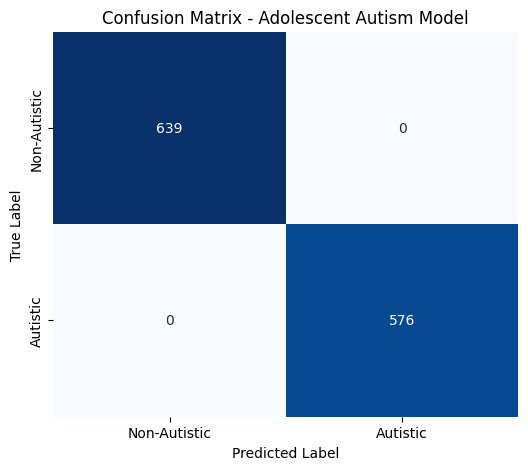

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Threshold at 0.5

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Autistic', 'Autistic'],
            yticklabels=['Non-Autistic', 'Autistic'])
plt.title('Confusion Matrix - Adolescent Autism Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Save to Drive
plt.savefig('/content/drive/MyDrive/FYP/adolescent_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
